# Building an SER Emotion Classifier!

In this project, we aim to build a SER emotion classifier using the TESS dataset provided by the University of Toronto!

Our goal is to:
1. Retrieve Data
2. Explore Data
3. Augment Data
4. Process Data
5. Extract Features
6. Train Model
7. Test Model

In [10]:
#%pip install seaborn
#%pip install librosa
#%#pip install kagglehub
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM
from keras.callbacks import ModelCheckpoint
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import kagglehub

## Retrieving the Data

In [11]:
# download the dataset
tess_path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Path to dataset files:", tess_path)

Path to dataset files: C:\Users\IO\.cache\kagglehub\datasets\ejlok1\toronto-emotional-speech-set-tess\versions\1


In [38]:
emotions = []
file_paths = []

for root, dirs, files in os.walk(tess_path):
    for file in files:
        if file.endswith('.wav'):
            emotion = os.path.basename(root) # take base name as emotion
            emotions.append(emotion)
            file_paths.append(os.path.join(root, file))

data_df = pd.DataFrame({
    'Emotion': emotions,
    'File_Path': file_paths
})

print(data_df.head())

     Emotion                                          File_Path
0  OAF_angry  C:\Users\IO\.cache\kagglehub\datasets\ejlok1\t...
1  OAF_angry  C:\Users\IO\.cache\kagglehub\datasets\ejlok1\t...
2  OAF_angry  C:\Users\IO\.cache\kagglehub\datasets\ejlok1\t...
3  OAF_angry  C:\Users\IO\.cache\kagglehub\datasets\ejlok1\t...
4  OAF_angry  C:\Users\IO\.cache\kagglehub\datasets\ejlok1\t...


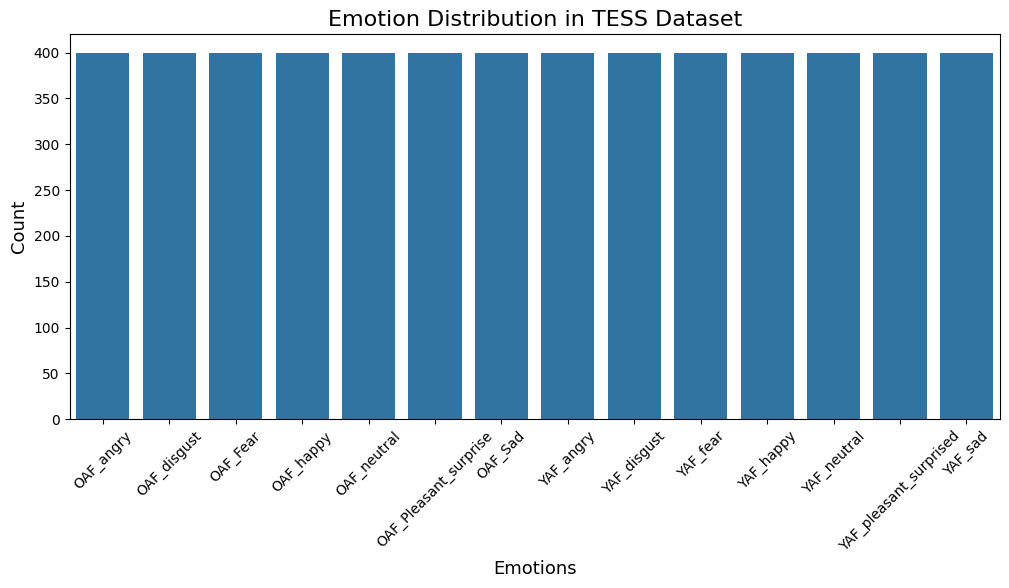

In [39]:
# emotion distribution!
plt.figure(figsize=(12, 5))
sns.countplot(data=data_df, x='Emotion', order=data_df['Emotion'].value_counts().index)
plt.title('Emotion Distribution in TESS Dataset', fontsize=16) # big font
plt.xlabel('Emotions', fontsize=13) # bigger font for clarity
plt.ylabel('Count', fontsize=13) # bigger font for clarity
plt.xticks(rotation=45) # rotate them since the words are long
plt.show()

## Data Exploration!

Here, we understand and explore the TESS dataset.

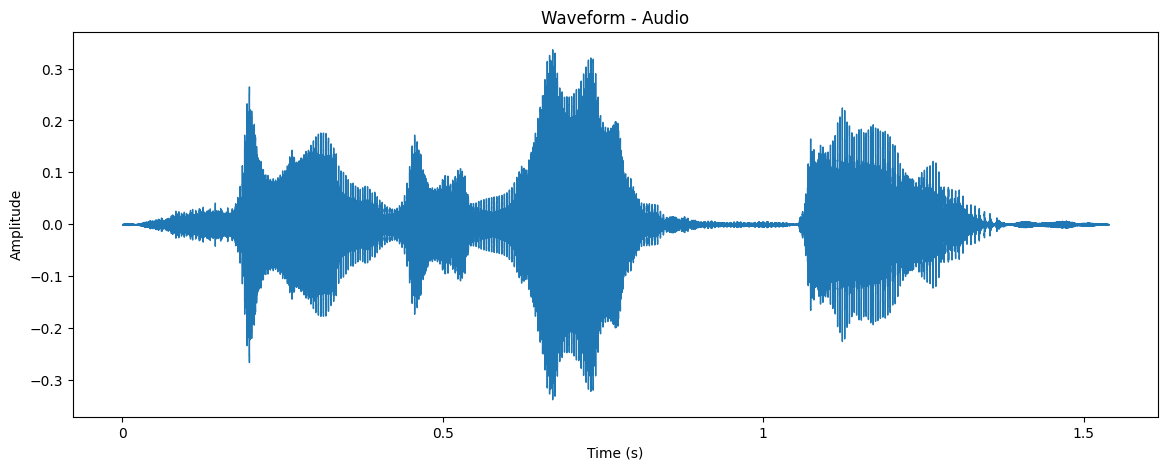

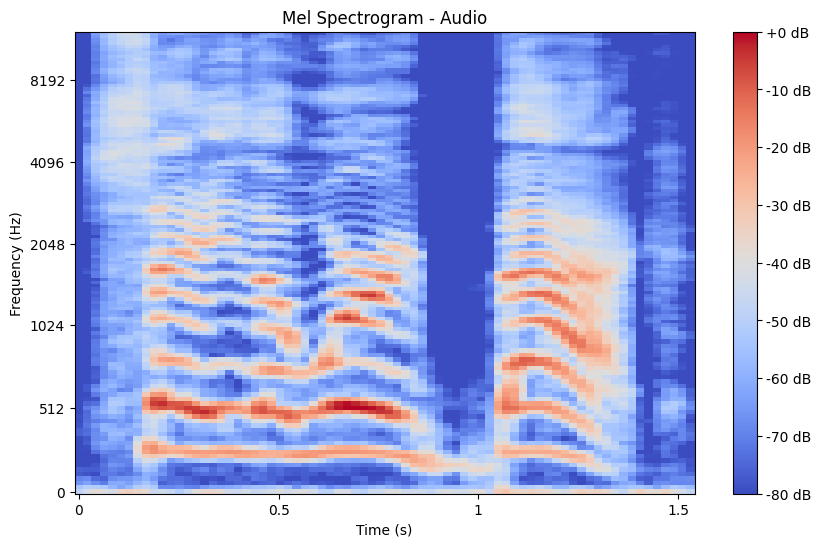

In [74]:
def load_audio(file_path):
    data, sr = librosa.load(file_path, sr=None) # audio with original sample
    return data, sr

def visualize_and_play(data, sr, title="Audio", size=(14,5)):
    """
    Visualize the waveform and play the audio.
    """
    plt.figure(figsize=size)
    plt.title(f"Waveform - {title}")
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    
    return Audio(data, rate=sr)

def plot_spectrogram(data, sr, title="Audio", size=(10, 6)):
    """
    Plot the mel spectrogram from audio data.
    """
    spectrogram = librosa.feature.melspectrogram(y=data, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    plt.figure(figsize=size)
    plt.title(f"Mel Spectrogram - {title}")
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

original_data, sr = load_audio(data_df.loc[0, 'File_Path'])
audio_player = visualize_and_play(original_data, sr)
plot_spectrogram(original_data, sr)
audio_player

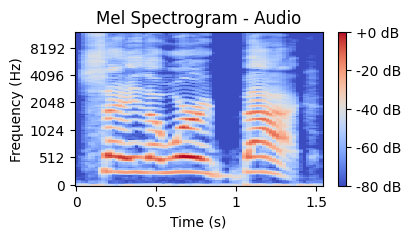

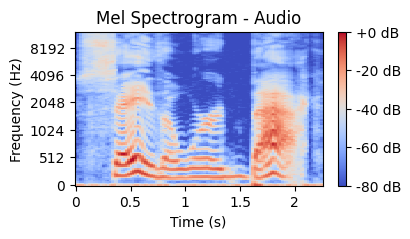

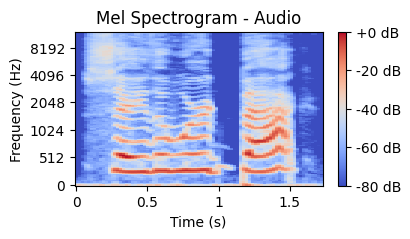

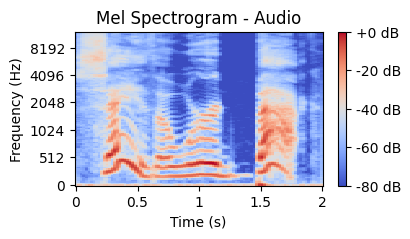

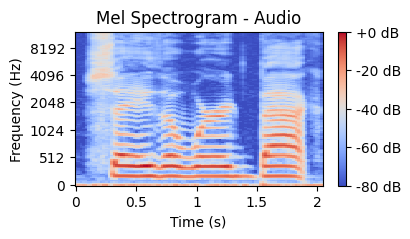

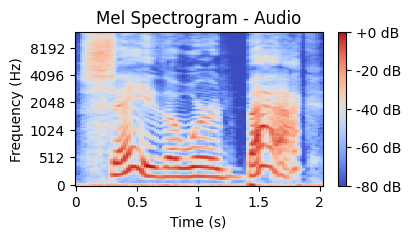

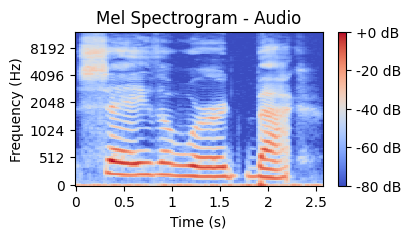

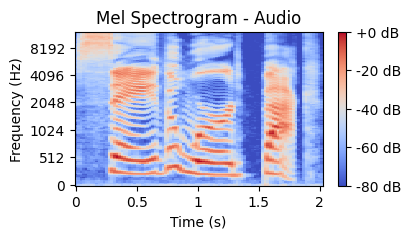

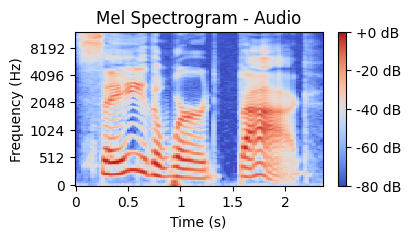

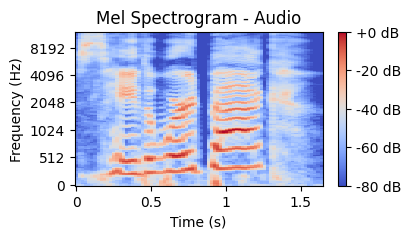

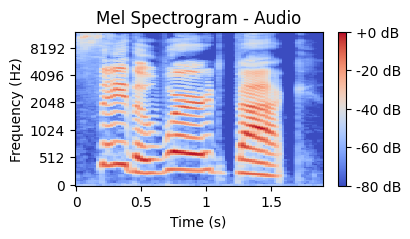

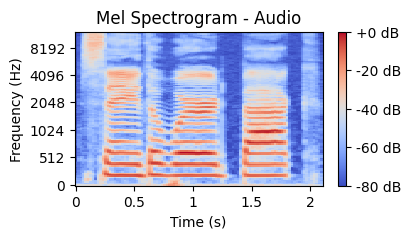

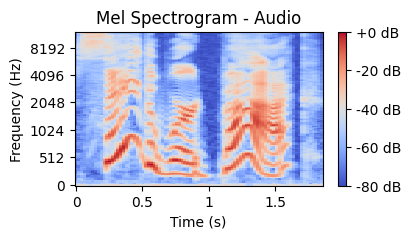

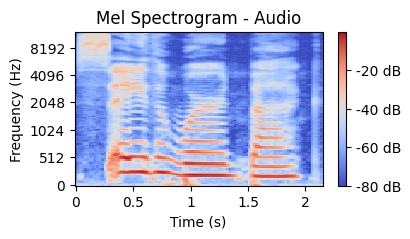

In [119]:
unique_emotions = data_df['Emotion'].unique()
for emotion in unique_emotions:
    sample_file = data_df[data_df['Emotion'] == emotion].iloc[0]['File_Path']
    original_data, sr = load_audio(sample_file)
    plot_spectrogram(original_data, sr, size=(4,2))

## Data Augmentation

Since our dataset is quite small in size, we will use data augmentation strategies to help increase diversity.

We will implement:
1. Noise Injection
2. Time Stretching
3. Pitch Shifting

We add elements of randomness to the augmentation, while also keeping a boundary to help better improve generalization

In [105]:
def noise(data, noise_factor_range=(0.01, 0.05)):
    noise_factor = np.random.uniform(*noise_factor_range)  # randomness in noise
    noise_amp = noise_factor * np.max(data)
    return data + noise_amp * np.random.normal(size=data.shape)

def stretch(data, rate_range=(0.8, 1.2)):
    rate = np.random.uniform(*rate_range)  # random stretching
    while rate == 1:  # if we get 1, make sure there is.
        rate = np.random.uniform(*rate_range)
    return librosa.effects.time_stretch(data, rate=rate)

def pitch(data, sr, n_steps_range=(-4, 4)):
    n_steps = np.random.randint(*n_steps_range)  # random shifting of pitch
    while n_steps == 0: #if no pitch change, ensure it
        n_steps = np.random.randint(*n_steps_range)
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)


In [109]:
def augment_audio(data, sr):
    augmented_data = [data]
    augmented_data.append(noise(data))
    augmented_data.append(stretch(data))
    augmented_data.append(pitch(data, sr))
    return augmented_data

Playing: Original


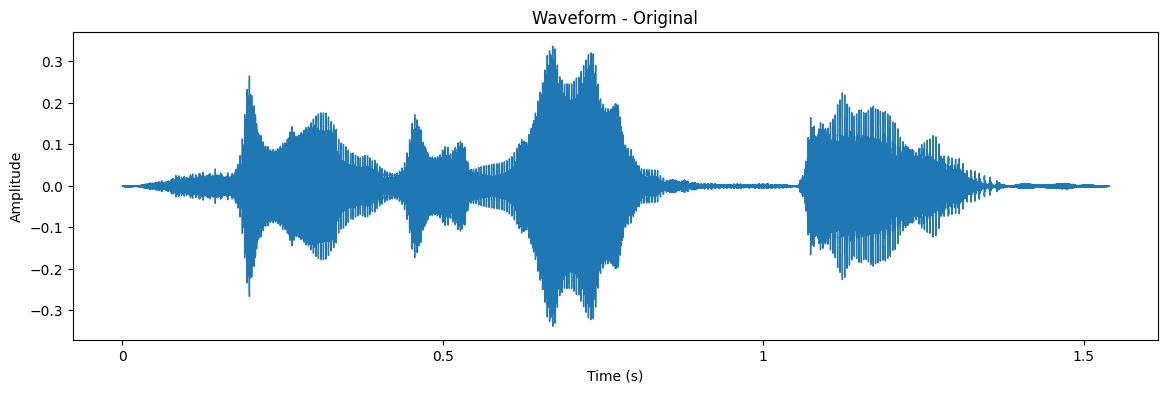

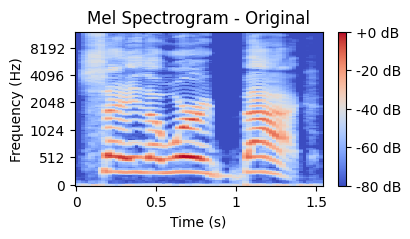

Playing: Noise Added


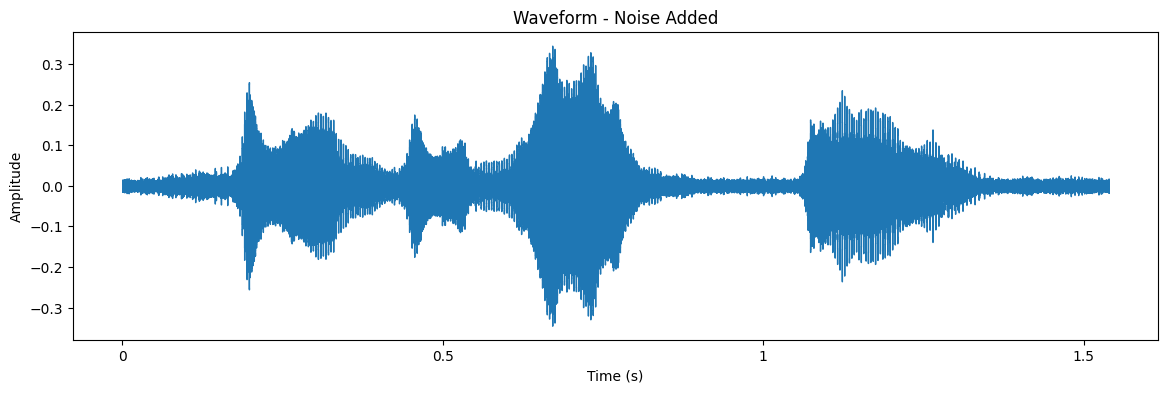

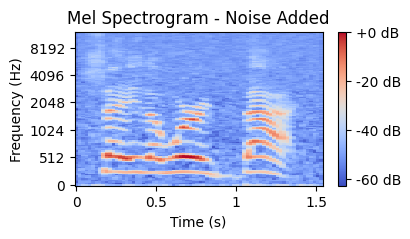

Playing: Time Stretched


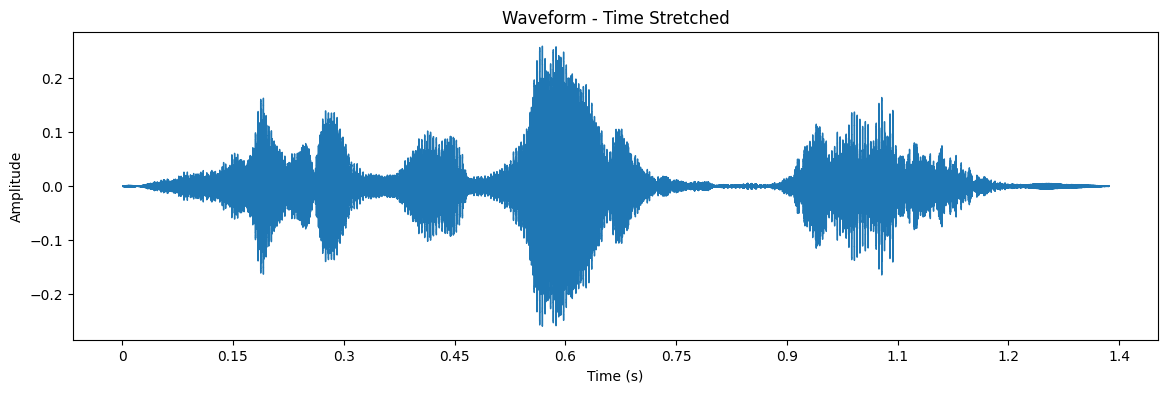

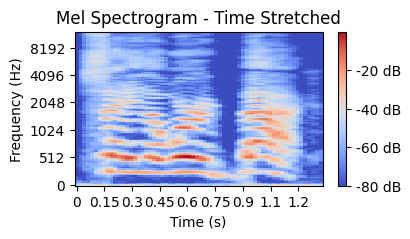

Playing: Pitch Shifted


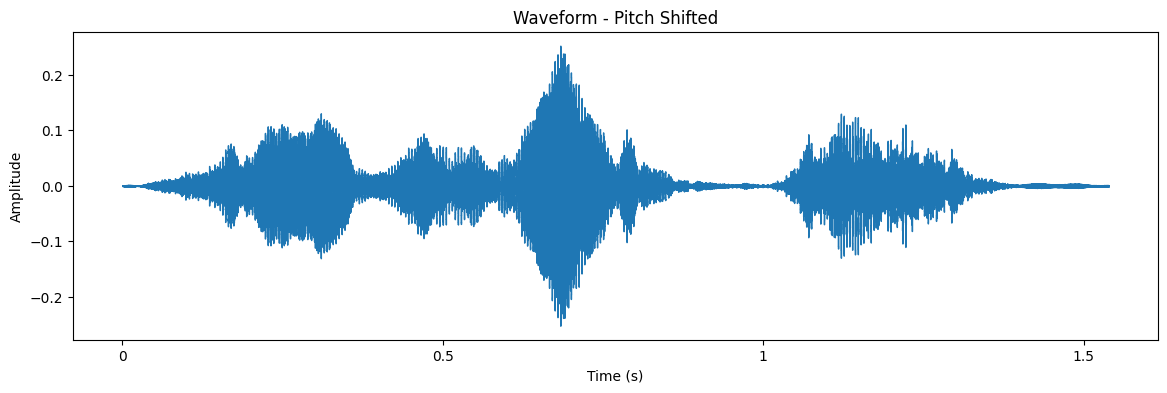

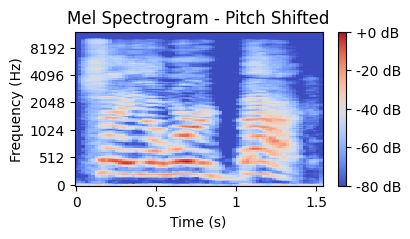

In [ ]:
sample_file = data_df.loc[0, 'File_Path']
original_data, sr = load_audio(sample_file)

augmented_versions = augment_audio(original_data, sr)
titles = ["Original", "Noise Added", "Time Stretched", "Pitch Shifted"]

for i, augmented_data in enumerate(augmented_versions):
    print(f"Playing: {titles[i]}")
    audio_player = visualize_and_play(augmented_data, sr, title=titles[i], size=(14,4))
    display(audio_player)
    plot_spectrogram(augmented_data, sr, title=titles[i], size=(4,2))

In [111]:
def augment_dataset(data_df):
    """
    Augment the entire dataset by applying augmentation to each audio file.
    """
    augmented_audio = []
    emotions = []

    for _, row in data_df.iterrows():
        file_path = row['File_Path']
        emotion = row['Emotion']
        raw_data, sr = load_audio(file_path)
        # augment
        augmented_versions = augment_audio(raw_data, sr)
        
        # add to dataset
        for augmented_data in augmented_versions:
            augmented_audio.append(augmented_data)
            emotions.append(emotion)  # Same label for all augmented versions

    # Return the augmented dataset
    return augmented_audio, emotions, sr

augmented_audio, augmented_emotions, sr = augment_dataset(data_df)
augmented_data_df = pd.DataFrame({
    'Emotion': augmented_emotions,
    'Audio_Data': augmented_audio
})
data_df['Audio_Data'] = data_df['File_Path'].apply(lambda path: load_audio(path)[0])
full_data_df = pd.concat([data_df[['Emotion', 'Audio_Data']], augmented_data_df], ignore_index=True)
print(full_data_df.head())
print(f"Total samples in combined dataset: {len(full_data_df)}")

     Emotion                                         Audio_Data
0  OAF_angry  [0.0, -0.00018310547, -0.0002746582, -0.000244...
1  OAF_angry  [0.0, -9.1552734e-05, -9.1552734e-05, -0.00018...
2  OAF_angry  [0.0, 3.0517578e-05, 6.1035156e-05, 3.0517578e...
3  OAF_angry  [0.0, -0.00015258789, -0.00015258789, -3.05175...
4  OAF_angry  [0.0, -3.0517578e-05, -3.0517578e-05, -0.00030...
Total samples in combined dataset: 28000


## Audio Preprocessing

Now, we need to do 4 main things.
1. Resample the audio to 16k
2. Remove silence segments
3. Keep a fixed duration
4. Normalize the Amplitude

In [114]:
def preprocess_audio(data, sr, target_sr=16000, duration=2.5):
    # resample ti 16k
    if sr != target_sr:
        data = librosa.resample(data, orig_sr=sr, target_sr=target_sr)
    
    # trim silence
    data, _ = librosa.effects.trim(data)

    # normalize amp
    data = librosa.util.normalize(data)

    # pad/truncate
    max_length = int(target_sr * duration)
    if len(data) > max_length:
        data = data[:max_length]  # Truncate
    else:
        data = np.pad(data, (0, max_length - len(data)))  # Pad

    return data, target_sr

Original


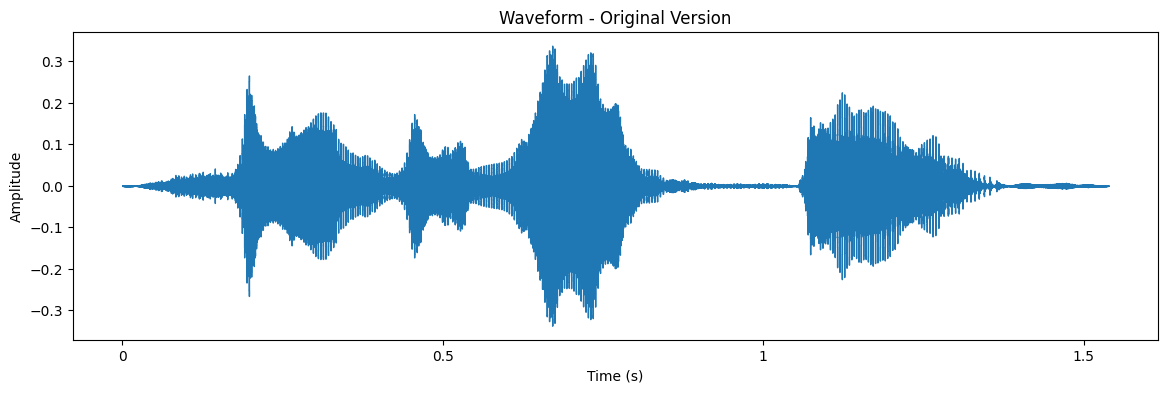

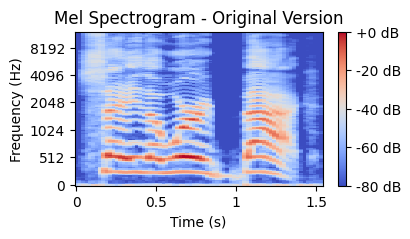

Preprocessed


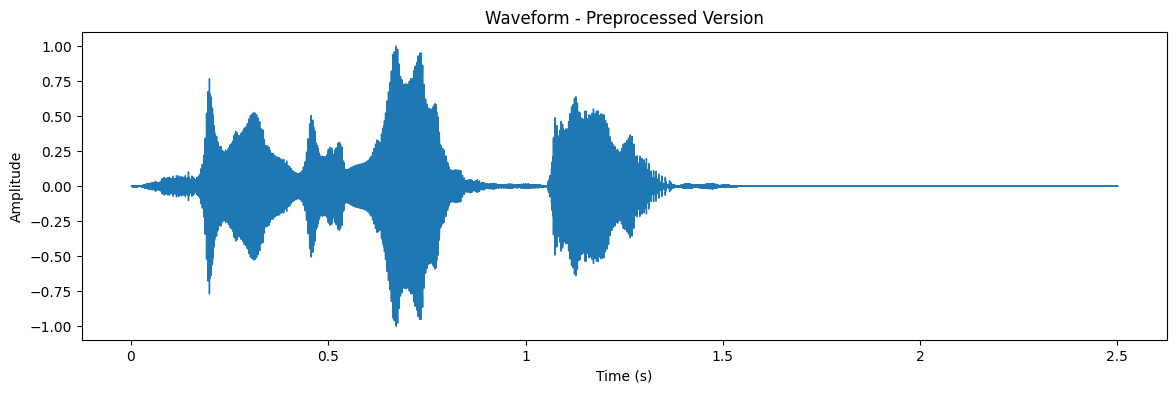

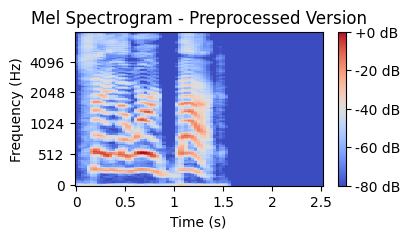

In [117]:
sample_file = data_df.loc[0, 'File_Path']
original_data, sr = load_audio(sample_file)

print("Original")
audio_player = visualize_and_play(original_data, sr, title="Original Version", size=(14,4))
display(audio_player)
plot_spectrogram(original_data, sr, title="Original Version", size=(4,2))

preprocessed_version, sr = preprocess_audio(original_data, sr)

print("Preprocessed")
audio_player = visualize_and_play(preprocessed_version, sr, title="Preprocessed Version", size=(14,4))
display(audio_player)
plot_spectrogram(preprocessed_version, sr, title="Preprocessed Version", size=(4,2))

In [118]:
def preprocess_dataset(data_df, target_sr=16000, duration=2.5):
    """
    Preprocess all audio samples in the dataset.
    - Applies preprocessing to both original and augmented data.
    """
    preprocessed_audio = []

    for audio_data in data_df['Audio_Data']:
        processed_audio, _ = preprocess_audio(audio_data, sr=target_sr, target_sr=target_sr, duration=duration)
        preprocessed_audio.append(processed_audio)

    return np.array(preprocessed_audio)

X_preprocessed = preprocess_dataset(full_data_df, target_sr=16000, duration=2.5)
y = full_data_df['Emotion']  # Labels

In [ ]:
#Run optionally
#np.save('X_preprocessed.npy', X_preprocessed)
#np.save('y_labels.npy', y)

# load preprocessed data when needed
# X_preprocessed = np.load('X_preprocessed.npy')
# y = np.load('y_labels.npy')

## Extracting Features

In [ ]:
def extract_melspectrogram(data, sr=16000, n_mels=64, n_fft=1024, hop_length=512):
    S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length) #get mel-spec
    S_dB = librosa.power_to_db(S, ref=np.max) # convert to log scale
    return S_dB

# still working on it!